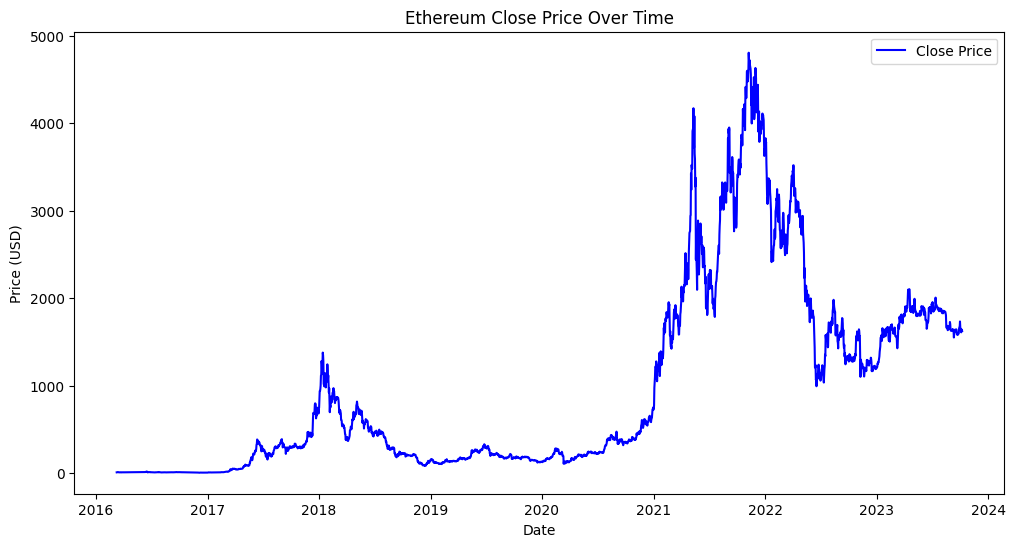

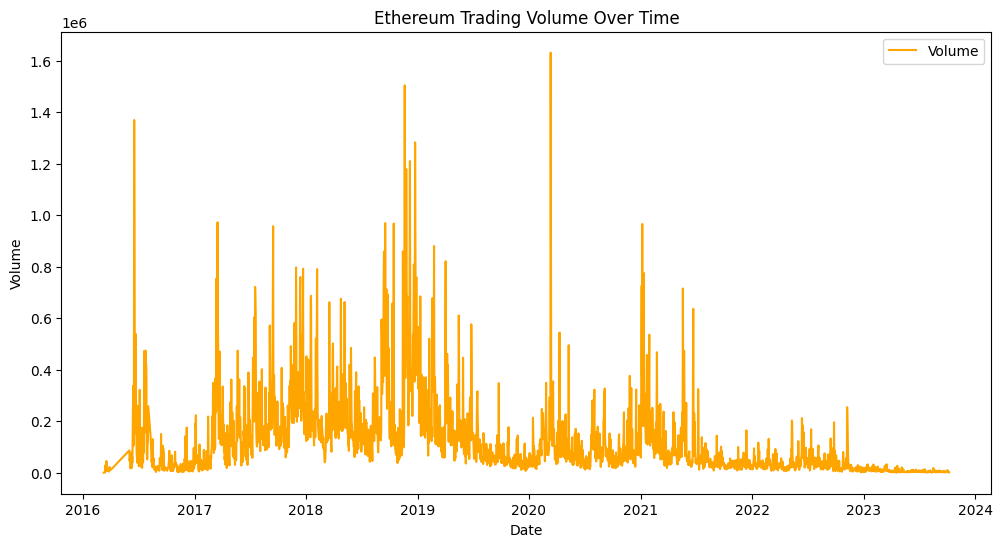

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('../../data/ethusd_group_project.csv')
df['time'] = pd.to_datetime(df['time'])
# Plot Close price
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label="Close Price", color='blue')
plt.title("Ethereum Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Plot Volume
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['volume'], label="Volume", color='orange')
plt.title("Ethereum Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

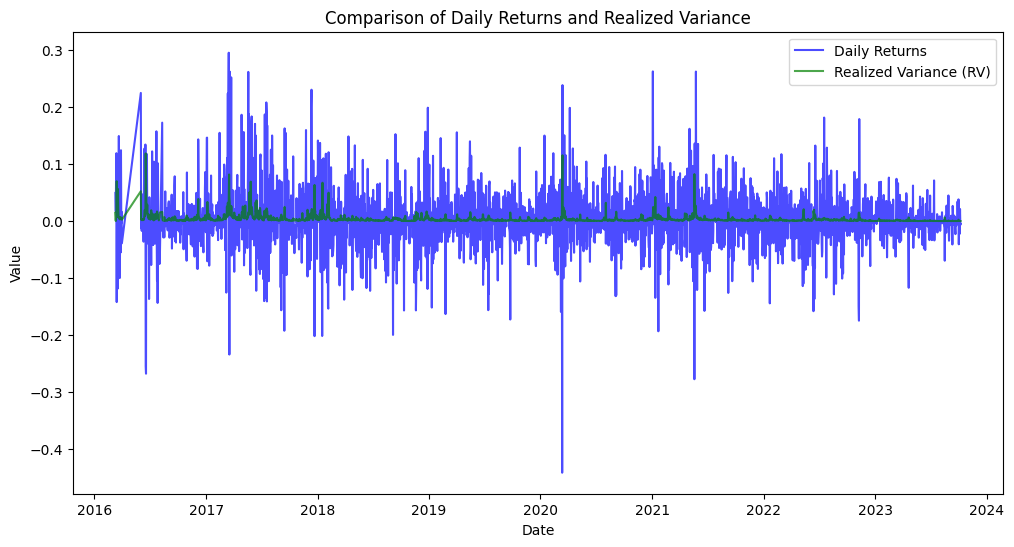

In [10]:
# Compare Daily Returns and Realized Variance
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['daily_return'], label="Daily Returns", color='blue', alpha=0.7)
plt.plot(df['time'], df['realized_variance'], label="Realized Variance (RV)", color='green', alpha=0.7)
plt.title("Comparison of Daily Returns and Realized Variance")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()